In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# Technically not necessary in newest versions of jupyter
%matplotlib inline

Using TensorFlow backend.


In [3]:
image_shape = (150,150,3)

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [5]:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=image_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

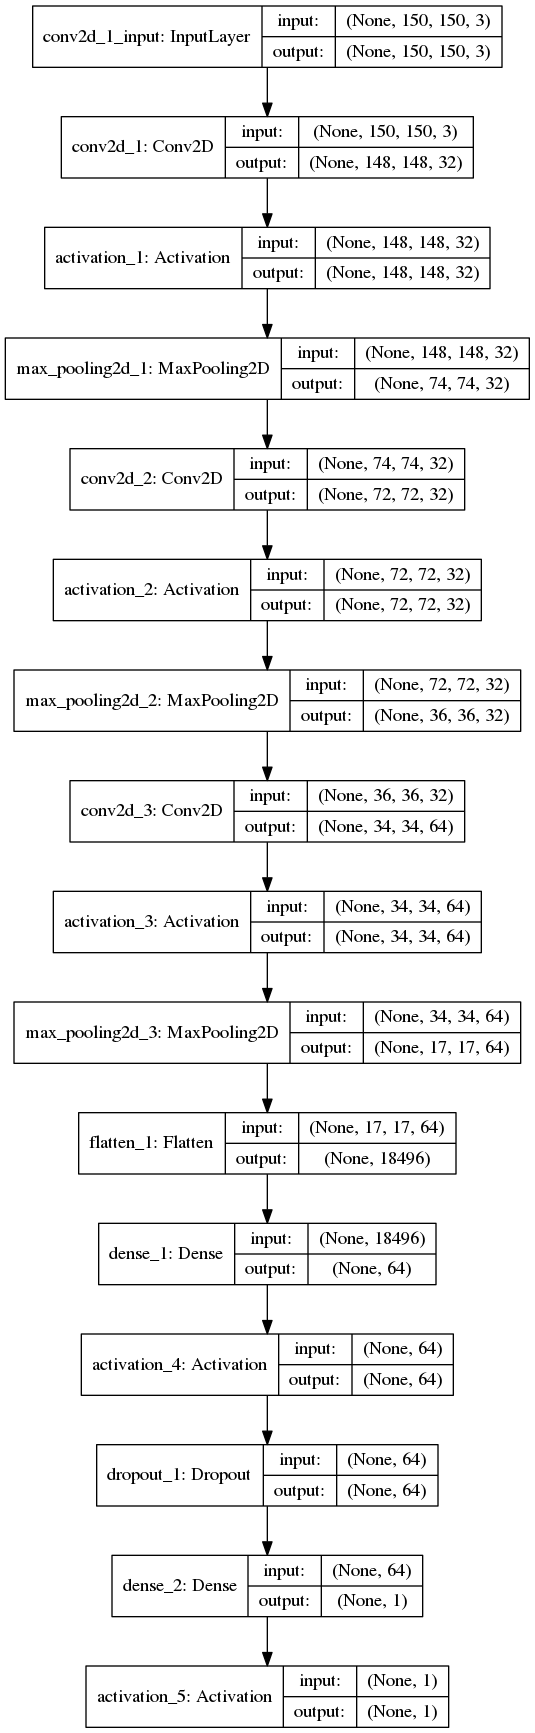

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Generating Data

In [7]:
import cv2
from PIL import Image

In [9]:
import cv2
import numpy as np
from PIL import Image
def change_brightness(image):
    image = np.array(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img2 = np.zeros_like(image)
    img2[:,:,0] = gray
    img2[:,:,1] = gray
    img2[:,:,2] = gray
    return img2

In [10]:
image_gen = ImageDataGenerator(rotation_range=1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               rescale=1/255,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 2],
                                preprocessing_function = change_brightness,
                               #fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                               validation_split=0.2,
                              )

In [11]:
batch_size = 30

train_image_gen = image_gen.flow_from_directory('../input/cnrpark/cnr-park-v2/cnr-park/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               shuffle=True,
                                               subset='training')

Found 9062 images belonging to 2 classes.


In [12]:
valid_image_gen = image_gen.flow_from_directory('../input/cnrpark/cnr-park-v2/cnr-park/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               shuffle=True,
                                               subset='validation')

Found 2264 images belonging to 2 classes.


In [13]:
test_gen = ImageDataGenerator(rotation_range=15, # rotate the image 30 degrees
                               #width_shift_range=0.1, # Shift the pic width by a max of 10%
                               #height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               #shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               #zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               #fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

test_image_gen = test_gen.flow_from_directory('../input/cnrpark/cnr-park-v2/cnr-park/test',
                                               target_size=image_shape[:2],
                                               batch_size=1,
                                               class_mode='binary')

Found 1258 images belonging to 2 classes.


In [14]:
train_image_gen.class_indices

{'busy': 0, 'free': 1}

In [17]:
# history = model.fit_generator(train_image_gen,epochs=10,
#                               steps_per_epoch=150,
#                               validation_data=test_image_gen,
#                              validation_steps=12)

history = model.fit_generator(train_image_gen,epochs=7,
                              steps_per_epoch=train_image_gen.samples/10,
                              validation_data=valid_image_gen,
                             validation_steps=valid_image_gen.samples/10)

Epoch 1/2
907/906 [==============================] - 217s 240ms/step - loss: 0.3663 - accuracy: 0.8510 - val_loss: 0.2583 - val_accuracy: 0.9469
Epoch 2/2
907/906 [==============================] - 219s 242ms/step - loss: 0.3404 - accuracy: 0.8668 - val_loss: 0.1974 - val_accuracy: 0.9364


In [16]:
model.save('moretransform.h5')
STEP_SIZE_TEST=test_image_gen.n//test_image_gen.batch_size

test_score = model.evaluate_generator(generator=test_image_gen,
steps=STEP_SIZE_TEST)

print("Test Accuracy: " + str(test_score[1]))
print("Test Loss: " + str(test_score[0]))

Test Accuracy: 0.8108108043670654
Test Loss: 0.009437475353479385


In [ ]:
fig = plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

fig.savefig('acc_loss_plot.png',dpi=300, bbox_inches = "tight")

# Data Distribution

In [ ]:
rootDir = "../input/cnrpark/cnr-park-v2/cnr-park/train"
free = 0
busy = 0
for dirName, subdirList, fileList in os.walk(rootDir):
    print(dirName)
    for fname in fileList:
        if (dirName == "../input/cnrpark/cnr-park-v2/cnr-park/train/free"):
            free += 1
        elif (dirName == "../input/cnrpark/cnr-park-v2/cnr-park/train/busy"):
            busy += 1
print("Free: " + str(free))
print("Busy: " + str(busy))

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
categories = ['busy', 'free']
count = [busy,free]
ax.bar(categories,count)
plt.title('distribution of data')
plt.ylabel('count')
plt.xlabel('categories')
plt.show()
fig.savefig('distribution.png',dpi=300, bbox_inches = "tight")

# Using the Data

In [ ]:
from keras.preprocessing import image

![](http://)![](http://)

In [ ]:
# Predicting on all the busy images - training
free = 0
busy = 0
for dirname, _, filenames in os.walk('/kaggle/input/cnrpark/cnr-park-v2/cnr-park/train/busy/'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename);
        img = image.load_img(filepath, target_size=image_shape)
        img = image.img_to_array(img)
        img = img.reshape((-1, 150, 150, 3))

        img.shape
        for text, index in train_image_gen.class_indices.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
            if index == model.predict(img)[0]:
                if (text == "free"):
                    free += 1
                else:
                    busy += 1
print("busy: ", busy)
print("free: ", free)
        

In [ ]:
# Predicting on all the busy images - test
free = 0
busy = 0
for dirname, _, filenames in os.walk('/kaggle/input/cnrpark/cnr-park-v2/cnr-park/test/busy/'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename);
        img = image.load_img(filepath, target_size=image_shape)
        img = image.img_to_array(img)
        img = img.reshape((-1, 150, 150, 3))

        img.shape
        for text, index in train_image_gen.class_indices.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
            if index == model.predict(img)[0]:
                if (text == "free"):
                    free += 1
                else:
                    busy += 1
print("busy: ", busy)
print("free: ", free)
        

In [ ]:
# Predicting on all the free images - training
free = 0
busy = 0
for dirname, _, filenames in os.walk('/kaggle/input/cnrpark/cnr-park-v2/cnr-park/train/free/'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename);
        img = image.load_img(filepath, target_size=image_shape)
        img = image.img_to_array(img)
        img = img.reshape((-1, 150, 150, 3))

        img.shape
        for text, index in train_image_gen.class_indices.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
            if index == model.predict(img)[0]:
                if (text == "free"):
                    free += 1
                else:
                    busy += 1
print("busy: ", busy)
print("free: ", free)
        

In [ ]:
# Predicting on all the free images - testing
free = []
free_test = []
# busy = 0
for dirname, _, filenames in os.walk('/kaggle/input/cnrpark/cnr-park-v2/cnr-park/test/free/'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename);
        img = image.load_img(filepath, target_size=image_shape)
        img = image.img_to_array(img)
        img = img.reshape((-1, 150, 150, 3))

        img.shape
        for text, index in train_image_gen.class_indices.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
            if index == model.predict(img)[0]:
                free_test.append(1)
                if (text == "free"):
                    free.append(1)
                else:
                    free.append(0)
print("busy: ", busy)
print("free: ", free)

In [ ]:
# 72 % Accuracy

In [ ]:
y_test = [1,0,1,0,1,0,1]
y_pred = [1,1,1,1,1,0,1]

In [ ]:
import matplotlib.pyplot as plot
plot.scatter([i for i in range(len(free_test))],free_test, marker='.' )
plot.scatter([i for i in range(len(free_test))], free, marker='.' ,color='red')
plot.title("W2V + LR")
plot.xlabel("Data points")
plot.ylabel("Tags")
plot.show()